# Determining the stability of the fits
After doing a fit, it is quite common to validate the result that has been obtained, since the stability and the type of minimum (global or local) is not reflected by the FCN or by the minimizer. In this section, several tools meant to evaluate the quality of the fits, and included in the Minkit package, are discussed.

## Scanning the FCN
The most common operation to do after a fit is to scan the profile of the FCN for the variables involved in it. This can be done in many different ways: fixing the rest of the parameters and evaluating the minimization function, mapping the full paramter space by varing all the parameters, or doing a fit for fixed values of one of the parameters (typically done by MINOS). In the Minkit package an easy and fast solution to the first two items is proposed using the *minkit.fcn_profile* function. Let's see how to do it on a fit to a Gaussian function.

In [1]:
%matplotlib inline
import minkit

x = minkit.Parameter('x', bounds=(-4, +4))
c = minkit.Parameter('c', 0., bounds=(-1, +1))
s = minkit.Parameter('s', 1., bounds=(0.7, 1.3))
g = minkit.Gaussian('g', x, c, s)

data = g.generate(10000)

with minkit.minimizer('uml', g, data) as minimizer:
    result = minimizer.migrad()

FCN = 28257.803801867896 
 TOTAL NCALL = 92 
 NCALLS = 92 
 
 
 EDM = 5.589309293901719e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,c,-0.00837095,0.00995019,,,-1,1,No
1,s,0.99453,0.00706184,,,0.7,1.3,No


In order to scan the variables, we must define the points to be evaluated as a numpy array.

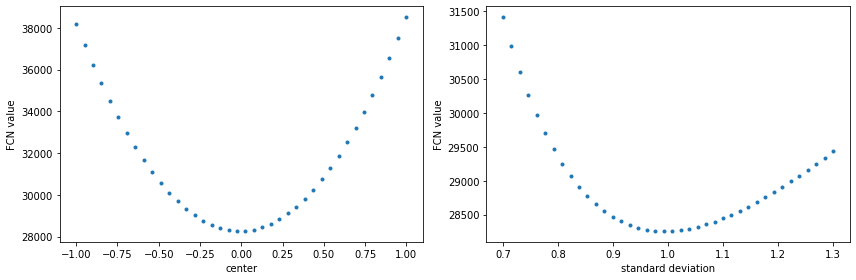

In [2]:
import numpy as np

c_scan = np.linspace(*c.bounds, 40)
s_scan = np.linspace(*s.bounds, 40)

with minkit.minimizer('uml', g, data) as minimizer:
    c_fcn = minimizer.fcn_profile('c', c_scan)
    s_fcn = minimizer.fcn_profile('s', s_scan)

import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))

ax0.plot(c_scan, c_fcn, '.');
ax0.set_xlabel('center');
ax0.set_ylabel('FCN value');
ax1.plot(s_scan, s_fcn, '.');
ax1.set_xlabel('standard deviation');
ax1.set_ylabel('FCN value');

fig.tight_layout()

In case we want to map the two-dimensional parameter space, we just need to specify the two parameters as input variables and define the values as a grid.

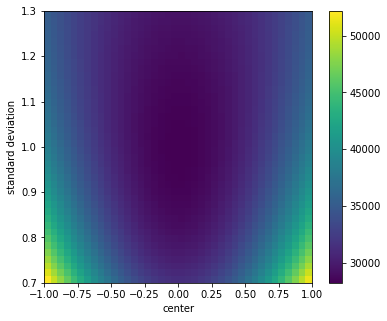

In [3]:
grid = np.array([a.flatten() for a in np.meshgrid(c_scan, s_scan)])

with minkit.minimizer('uml', g, data) as minimizer:
    fcn = minimizer.fcn_profile(('c', 's'), grid)[::-1] # need to reverse for "imshow"

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

fcn = fcn.reshape((len(c_scan), len(s_scan)))

m = ax.imshow(fcn, extent=(*c.bounds, *s.bounds), aspect = 'auto')
ax.set_xlabel('center');
ax.set_ylabel('standard deviation');
fig.colorbar(m, ax=ax);

## Evaluating residuals and pulls
Another common operation that is performed once a fit is done is to look at the residuals or the pull plots of the binned distribution. To do this correctly, it is necessary that we evaluate the resulting PDF in the bins of the distribution, and thus a binned data set must be constructed. In the following lines we will plot the result of the fit together with the distribution of the residuals below.

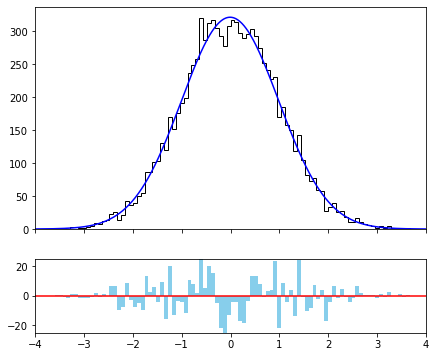

In [4]:
values, edges = minkit.data_plotting_arrays(data, bins=100)

gx, pdf_values = minkit.pdf_plotting_arrays(g, values, edges)

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(7, 6), gridspec_kw={'height_ratios': (3, 1)}, sharex=True)

centers = 0.5 * (edges[1:] + edges[:-1])

ax0.hist(centers, edges, weights=values, histtype='step', color='k');
ax0.plot(gx, pdf_values, color='blue');
ax1.plot(x.bounds, (0, 0), color='red');

binned_ds = minkit.BinnedDataSet.from_ndarray(edges, x, values)

pdf_r = values.sum() * g.evaluate_binned(binned_ds).as_ndarray() # evaluate_binned is normalized to unity

res = values - pdf_r

pos = res > 0

w = edges[1] - edges[0]

ax1.bar(centers[pos], res[pos], width=w, color='skyblue');
ax1.bar(centers[~pos], res[~pos], width=w, color='skyblue');
ax1.set_xlim(*x.bounds)
ax1.set_ylim(-25, +25);